# Hinglish Code-Mixing Analysis (en-IN Sarcasm)

This notebook implements an end-to-end analysis of Hinglish code-mixing for the English-India (en-IN) Reddit Sentiment dataset from the BESSTIE repository.

**Scope:**
- Task: Sentiment Detection
- Variety: en-IN (Reddit)
- Feature: Hinglish Code-Mixing (CMS)
- Method: FastText Language ID based detection

In [13]:
!unzip Archive.zip

In [12]:
!pip -q install wordfreq
!pip -q install spacy
!python -m spacy download en_core_web_sm -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 849.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.1/183.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 45.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## 1. Environment Setup

In [14]:
import os
import re
import glob
import urllib.request
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Check if running from repo root
cwd = os.getcwd()
print(f"Current Working Directory: {cwd}")

# Verify dataset paths
TRAIN_PATH = "Dataset/Splits/Sentiment/en-IN/Reddit/train.csv"
VALID_PATH = "Dataset/Splits/Sentiment/en-IN/Reddit/valid.csv"
TEST_PATH = "Dataset/Splits/Sentiment/en-IN/Reddit/test.csv"


if not os.path.exists(TRAIN_PATH):
    raise FileNotFoundError(f"Train dataset not found at {TRAIN_PATH}")
if not os.path.exists(VALID_PATH):
    raise FileNotFoundError(f"Valid dataset not found at {VALID_PATH}")
print("Dataset paths verified.")

Current Working Directory: /content
Dataset paths verified.


In [15]:
# Install fasttext if not present
try:
    import fasttext
    print("fasttext already installed.")
except ImportError:
    print("fasttext not found. Installing...")
    !pip install fasttext
    import fasttext

# Download FastText Language ID model if missing
FT_MODEL_PATH = "lid.176.bin"
FT_MODEL_URL = "https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin"

if not os.path.exists(FT_MODEL_PATH):
    print(f"Downloading {FT_MODEL_PATH}...")
    urllib.request.urlretrieve(FT_MODEL_URL, FT_MODEL_PATH)
    print("Download complete.")
else:
    print(f"{FT_MODEL_PATH} already exists.")

# Load model
ft_model = fasttext.load_model(FT_MODEL_PATH)
print("FastText model loaded.")

fasttext already installed.
lid.176.bin already exists.
FastText model loaded.


## 2. Load Data

In [16]:
df_train = pd.read_csv(TRAIN_PATH)
df_valid = pd.read_csv(VALID_PATH)
df_test = pd.read_csv(TEST_PATH)


print(f"Train rows: {len(df_train)}")
print(f"Valid rows: {len(df_valid)}")
print(f"test rows: {len(df_test)}")

print("\nTrain Label Distribution:")
print(df_train['label'].value_counts())

print("\nSample Rows:")
display(df_train.head())

Train rows: 1685
Valid rows: 115
test rows: 115

Train Label Distribution:
label
0    1256
1     429
Name: count, dtype: int64

Sample Rows:


,text,label,variety,source,task
0,Zepto has a mandate that the delivery boy need...,1,en-IN,Reddit,Sentiment
1,Mujhe bhi thoda paisa do,0,en-IN,Reddit,Sentiment
2,Nooo don't protest against secular freedom fig...,0,en-IN,Reddit,Sentiment
3,Har 3 mahine baad kisi bhi global celebrity ko...,0,en-IN,Reddit,Sentiment
4,Just because you don't find anything serious b...,0,en-IN,Reddit,Sentiment


## 3. Text Preprocessing + Tokenizer

In [17]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', str(text))
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_and_filter(text):
    # Regex to capture words (with apostrophes/dashes) or emojis/symbols
    # We want to keep emojis but ignore pure punctuation for language ID check if strictly needed,
    # but for tokenizing we capture them.
    # Pattern matches words with optional internal apostrophes or dashes, OR non-whitespace chars (symbols)
    tokens = re.findall(r"[A-Za-z]+(?:[\'-][A-Za-z]+)*|[^\w\s]", text)
    return tokens

def is_eligible(token):
    # len >= 4 and contains at least one alphabetic char
    if len(token) < 3:
        return False
    if not re.search(r'[a-zA-Z]', token):
        return False
    return True

# Test tokenizer
sample_text = "Nahi bhai, this is time-pass only! 😂"
print(f"Original: {sample_text}")
tokens = tokenize_and_filter(clean_text(sample_text))
print(f"Tokens: {tokens}")
print(f"Eligible: {[t for t in tokens if is_eligible(t)]}")

Original: Nahi bhai, this is time-pass only! 😂
Tokens: ['Nahi', 'bhai', ',', 'this', 'is', 'time-pass', 'only', '!', '😂']
Eligible: ['Nahi', 'bhai', 'this', 'time-pass', 'only']


## 4. Hinglish Code-Mixing Detector (Core)

In [18]:
import re
from wordfreq import zipf_frequency

HINGLISH_SEEDS = {
    "bhai","bhaiya","yaar","paisa","sarkar","desh","dost","wala","wali","bakwas",
    "chutiya","gaali","kya","kyu","kyun","haan","han","nahi","nahin","matlab",
    "jaldi","abhi","arre","arey","mast","bindaas","jugaad","pyaar","pyar"
}

TOKEN_RE = re.compile(r"[A-Za-z]+(?:[\'-][A-Za-z]+)*")

def clean_text_minimal(text: str) -> str:
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_words(text: str):
    return TOKEN_RE.findall(text)

def is_common_english(word: str, thr: float = 3.5) -> bool:
    # zipf_frequency: higher = more common
    return zipf_frequency(word, "en") >= thr

def looks_hinglish_romanized(word: str) -> bool:
    # very rough romanization cues
    markers = ("bh","kh","gh","ch","jh","sh","aa","ee","oo","ai","au","ya","ji")
    if any(m in word for m in markers):
        return True
    # endings often seen in romanized Hindi/Urdu
    if word.endswith(("wala","wali","ji","na","haan","nahin")):
        return True
    return False

def detect_hinglish_code_mixing(text: str):
    text = clean_text_minimal(str(text))
    tokens = [t.lower() for t in tokenize_words(text)]

    # eligible tokens, stricter to reduce noise
    eligible = [t for t in tokens if len(t) >= 4]

    if not eligible:
        return {
            "cm_hinglish_token_ratio": 0.0,
            "cm_switch_count": 0,
            "cm_score": 0.0,
            "is_cm": "False"
        }

    flags = []
    for t in eligible:
        if t in HINGLISH_SEEDS:
            flags.append(True)
            continue

        # only count as Hinglish if it looks romanized AND not common English
        if looks_hinglish_romanized(t) and (not is_common_english(t)):
            flags.append(True)
        else:
            flags.append(False)

    hinglish_count = sum(flags)
    cm_hinglish_token_ratio = hinglish_count / len(eligible)

    # switch count
    cm_switch_count = 0
    last = None
    for f in flags:
        cur = "HINGLISH" if f else "EN"
        if last is not None and cur != last:
            cm_switch_count += 1
        last = cur

    # score
    s1 = min(cm_hinglish_token_ratio / 0.30, 1.0)
    s2 = min(cm_switch_count / 5.0, 1.0)
    cm_score = 0.7 * s1 + 0.3 * s2


    if cm_score < 0.30:
        is_cm = "False"
    else:
        is_cm = "True"

    return {
        "cm_hinglish_token_ratio": float(cm_hinglish_token_ratio),
        "cm_switch_count": int(cm_switch_count),
        "cm_score": float(cm_score),
        "is_cm": is_cm
    }


## 5. Apply Detector to Datasets

In [19]:
from tqdm import tqdm
tqdm.pandas()

def apply_detector(df):
    results = df['text'].progress_apply(detect_hinglish_code_mixing)
    df_res = pd.DataFrame(results.tolist())
    return pd.concat([df, df_res], axis=1)

print("Processing Train Data...")
df_train_tagged = apply_detector(df_train)

print("Processing Valid Data...")
df_valid_tagged = apply_detector(df_valid)

print("Processing Valid Data...")
df_test_tagged = apply_detector(df_test)

# Save Tagged Outputs
train_out_path = "Dataset/Splits/Sentiment/en-IN/Reddit/train_tagged_cm.csv"
valid_out_path = "Dataset/Splits/Sentiment/en-IN/Reddit/valid_tagged_cm.csv"
test_out_path = "Dataset/Splits/Sentiment/en-IN/Reddit/test_tagged_cm.csv"

df_train_tagged.to_csv(train_out_path, index=False)
df_valid_tagged.to_csv(valid_out_path, index=False)
df_test_tagged.to_csv(test_out_path, index=False)

print(f"Saved tagged datasets to:\n{train_out_path}\n{valid_out_path}")

Processing Train Data...


100%|██████████| 1685/1685 [00:00<00:00, 3357.19it/s]


Processing Valid Data...


100%|██████████| 115/115 [00:00<00:00, 5082.40it/s]


Processing Valid Data...


100%|██████████| 115/115 [00:00<00:00, 5510.88it/s]


Saved tagged datasets to:
Dataset/Splits/Sentiment/en-IN/Reddit/train_tagged_cm.csv
Dataset/Splits/Sentiment/en-IN/Reddit/valid_tagged_cm.csv


In [20]:
# Distribution of CM Levels
print("Train CM Level Distribution:")
print(df_train_tagged['is_cm'].value_counts(normalize=True))

print("\nValid CM Level Distribution:")
print(df_valid_tagged['is_cm'].value_counts(normalize=True))

print("\nTest CM Level Distribution:")
print(df_test_tagged['is_cm'].value_counts(normalize=True))

Train CM Level Distribution:
is_cm
False    0.738279
True     0.261721
Name: proportion, dtype: float64

Valid CM Level Distribution:
is_cm
False    0.756522
True     0.243478
Name: proportion, dtype: float64

Test CM Level Distribution:
is_cm
False    0.765217
True     0.234783
Name: proportion, dtype: float64


In [21]:
# Sanity Check: Top 10 High cm_score examples from Train
print("Top 10 Code-Mixed Examples (Train):")
top_cm = df_train_tagged.sort_values(by='cm_score', ascending=False).head(10)
for idx, row in top_cm.iterrows():
    print(f"Score: {row['cm_score']:.2f} | Level: {row['is_cm']}")
    print(f"Text: {row['text']}")
    print("-"*50)

Top 10 Code-Mixed Examples (Train):
Score: 1.00 | Level: True
Text: "Mai sath me Ghar chala rhi hu " /s hanji bilkul.. Aap apne paise hi khud pe spend krlo wohi bhot h
--------------------------------------------------
Score: 1.00 | Level: True
Text: Yaar true incident mera exam tha aur center 1 ghanta dur tha aur meri tabiyat physically or mentally dono kharab thi , uss din bhagwan ne mze lene ke liye cab Wale ki car kharab karwa di 
Mujhe lekin itna gussa toh nhi aaya tha, exam centre par pahoch gya lekin 3-4 minute hi bache the,thanks to rapido
--------------------------------------------------
Score: 1.00 | Level: True
Text: bhai isme gender kaha se bich me aa gya....agar aadmiyo ko bhi sikha dete drone chalana to koi dikkat aa jata kya?
--------------------------------------------------
Score: 1.00 | Level: True
Text: Bichare samundar ke janwar pareshan ho gaye honge otne gaane bajane se
--------------------------------------------------
Score: 1.00 | Level: True
Text: wahi to jab

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

def cm_summary_table(df, split_name):
    # count by level
    level_order = ['False', 'True']
    counts = df['is_cm'].value_counts().reindex(level_order, fill_value=0)
    perc = (counts / len(df) * 100).round(2)

    # cm_score stats
    score_stats = df['cm_score'].describe()[['mean', 'std', 'min', '25%', '50%', '75%', 'max']].round(4)

    # build a neat table
    summary = pd.DataFrame({
        'split': split_name,
        'count': counts.values,
        'percent': perc.values
    }, index=level_order).reset_index().rename(columns={'index': 'is_cm'})

    return summary, score_stats

train_summary, train_score_stats = cm_summary_table(df_train_tagged, "train")
valid_summary, valid_score_stats = cm_summary_table(df_valid_tagged, "valid")
test_summary, test_score_stats = cm_summary_table(df_test_tagged, "test")

df_cm_table = pd.concat([train_summary, valid_summary], ignore_index=True)

print("CM Level Distribution (Train vs Valid):")
display(df_cm_table)

print("\nCM Score Stats - Train:")
display(train_score_stats.to_frame(name="train"))

print("\nCM Score Stats - Valid:")
display(valid_score_stats.to_frame(name="valid"))

print("\nCM Score Stats - Test:")
display(test_score_stats.to_frame(name="test"))


CM Level Distribution (Train vs Valid):


,is_cm,split,count,percent
0,False,train,1244,73.83
1,True,train,441,26.17
2,False,valid,87,75.65
3,True,valid,28,24.35



CM Score Stats - Train:


,train
mean,0.1837
std,0.2908
min,0.0000
25%,0.0000
50%,0.0000
75%,0.3191
max,1.0000



CM Score Stats - Valid:


,valid
mean,0.1852
std,0.3084
min,0.0000
25%,0.0000
50%,0.0000
75%,0.2702
max,1.0000



CM Score Stats - Test:


,test
mean,0.1710
std,0.2840
min,0.0000
25%,0.0000
50%,0.0000
75%,0.2735
max,1.0000


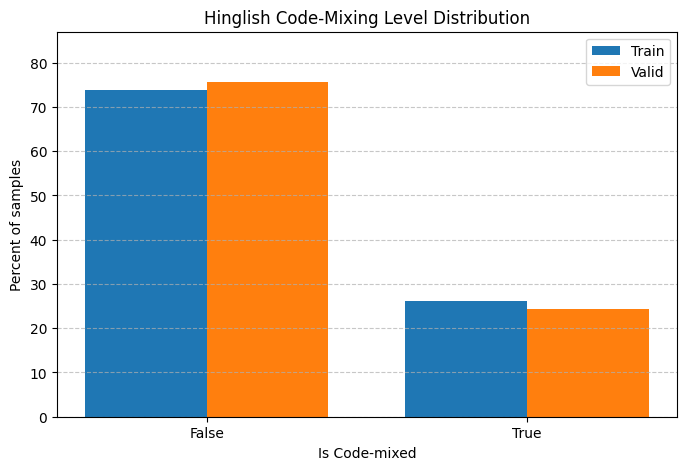

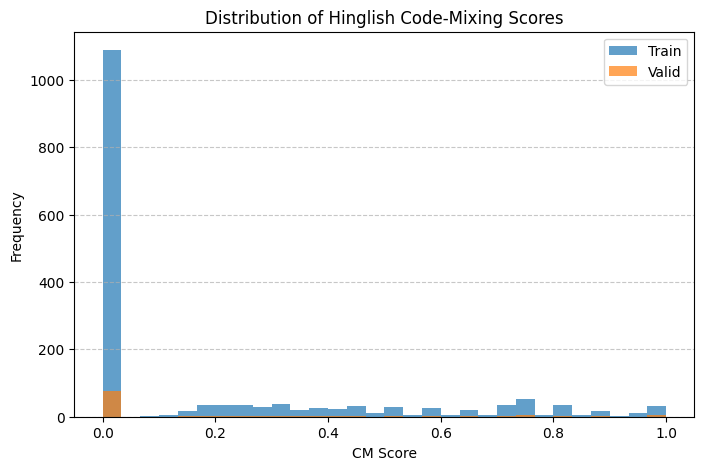

/tmp/ipython-input-2384627248.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_train_tagged['cm_score'].dropna(), df_valid_tagged['cm_score'].dropna()], labels=['Train', 'Valid'])


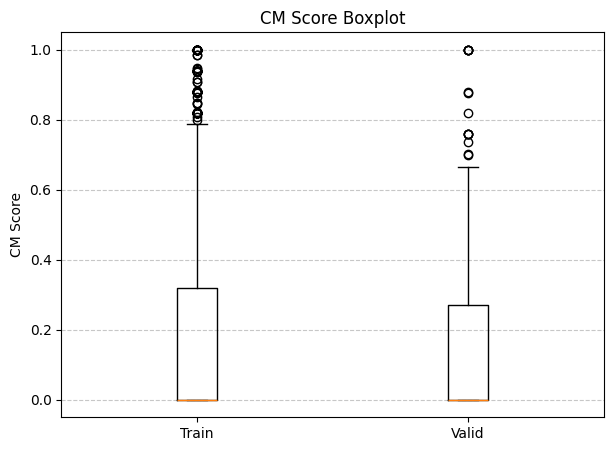

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# --- Bar chart: CM level distribution (percent) ---
level_order = ['False', 'True']


train_counts = df_train_tagged['is_cm'].value_counts().reindex(level_order, fill_value=0)
valid_counts = df_valid_tagged['is_cm'].value_counts().reindex(level_order, fill_value=0)

train_perc = train_counts / len(df_train_tagged) * 100
valid_perc = valid_counts / len(df_valid_tagged) * 100

x = np.arange(len(level_order))
width = 0.38

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, train_perc.values, width, label='Train')
plt.bar(x + width/2, valid_perc.values, width, label='Valid')
plt.xticks(x, level_order)
plt.title('Hinglish Code-Mixing Level Distribution')
plt.xlabel('Is Code-mixed')
plt.ylabel('Percent of samples')
plt.ylim(0, max(train_perc.max(), valid_perc.max()) * 1.15 if max(train_perc.max(), valid_perc.max()) > 0 else 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# --- Histogram: CM score distribution ---
plt.figure(figsize=(8, 5))
plt.hist(df_train_tagged['cm_score'], bins=30, alpha=0.7, label='Train')
plt.hist(df_valid_tagged['cm_score'], bins=30, alpha=0.7, label='Valid')
plt.title('Distribution of Hinglish Code-Mixing Scores')
plt.xlabel('CM Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# --- Optional: Boxplot for CM scores ---
plt.figure(figsize=(7, 5))
plt.boxplot([df_train_tagged['cm_score'].dropna(), df_valid_tagged['cm_score'].dropna()], labels=['Train', 'Valid'])
plt.title('CM Score Boxplot')
plt.ylabel('CM Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## 6. Model Evaluation Linkage (Valid Only)

In [29]:
# Find most recent prediction file
search_pattern = "Results/**/Sarcasm/en-IN/Reddit/prediction*.csv"
prediction_files = glob.glob(search_pattern, recursive=True)

if not prediction_files:
    print("WARNING: No prediction file found via pattern:", search_pattern)
    print("Checking simpler pattern `Results/**/prediction.csv` just in case...")
    prediction_files = glob.glob("Results/**/prediction.csv", recursive=True)
    # Filter manually for en-IN/Reddit if needed, but for now take what we found if we are desperate

if not prediction_files:
    print("ERROR: No prediction files found. Cannot compute evaluation metrics.")
else:
    # Sort by modification time, newest first
    latrain_pred_file = max(prediction_files, key=os.path.getmtime)
    print(f"Using prediction file: {latrain_pred_file}")

    df_preds = pd.read_csv(latrain_pred_file)

    # Assume predictions correspond to train set rows in order.
    # If lengths differ, we align by index up to min length.
    if len(df_preds) != len(df_train_tagged):
        print(f"Warning: Prediction count ({len(df_preds)}) != train set count ({len(df_train_tagged)}). Joining by index intersection.")

    # Join predictions with tagged train set
    # Check if 'prediction' in columns, otherwise might be 'pred' or similar. Usually 'prediction' in BESSTIE.
    pred_col = 'prediction' if 'prediction' in df_preds.columns else df_preds.columns[0] # Fallback

    df_eval = df_train_tagged.copy()
    df_eval['predicted_label'] = df_preds[pred_col]

    # Drop NaNs if any misalignment
    df_eval = df_eval.dropna(subset=['predicted_label'])

    # Compute F1 by Group
    groups = ['False', 'True']
    results = []

    for g in groups:
        sub = df_eval[df_eval['is_cm'] == g]
        count = len(sub)
        if count > 0:
            f1 = f1_score(sub['label'], sub['predicted_label'], zero_division=0)
        else:
            f1 = 0.0
        results.append({'is_cm': g, 'count': count, 'f1': f1})

    # Combined Medium+High
    sub_mh = df_eval[df_eval['is_cm'].isin(['True'])]

    count_mh = len(sub_mh)
    f1_mh = f1_score(sub_mh['label'], sub_mh['predicted_label'], zero_division=0) if count_mh > 0 else 0.0
    results.append({'is_cm': 'True', 'count': count_mh, 'f1': f1_mh})


    df_res_table = pd.DataFrame(results)
    print("\nPerformance by CM Level:")
    display(df_res_table)

    # Report Drop
    f1_none = df_res_table[df_res_table['is_cm'] == 'False']['f1'].values[0]
    f1_high = df_res_table[df_res_table['is_cm'] == 'True']['f1'].values[0]
    print(f"\nPerformance Drop (False -> True): {f1_none - f1_high:.4f}")

Using prediction file: Results/Qwen/Sarcasm/en-IN/Reddit/prediction.csv

Performance by CM Level:


,is_cm,count,f1
0,False,351,0.082645
1,True,128,0.000000
2,True,128,0.000000



Performance Drop (False -> True): 0.0826


## 7. Visualization

<Figure size 800x500 with 0 Axes>

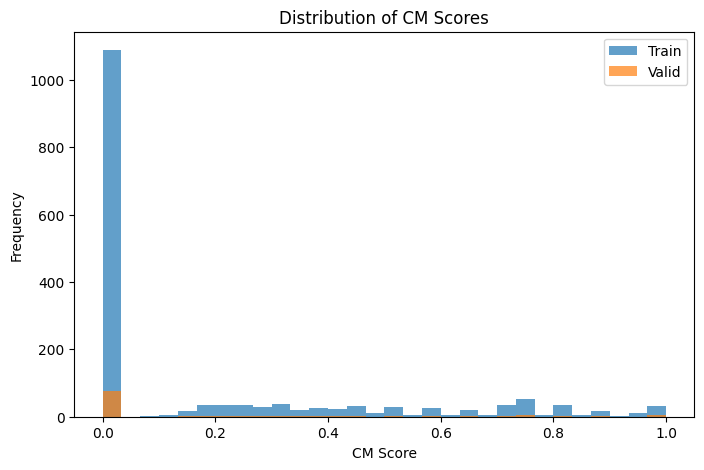

In [25]:
if 'df_res_table' in locals() and not df_res_table.empty:
    plt.figure(figsize=(8, 5))
    plot_data = df_res_table[df_res_table['is_cm'].isin(['False', 'True'])]




plt.figure(figsize=(8, 5))
plt.hist(df_train_tagged['cm_score'], bins=30, alpha=0.7, label='Train')
plt.hist(df_valid_tagged['cm_score'], bins=30, alpha=0.7, label='Valid')
plt.title('Distribution of CM Scores')
plt.xlabel('CM Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()